In [ ]:
%cd /content/drive/MyDrive/EMART/

/content/drive/MyDrive/EMART


In [ ]:
!pip install lightgbm==2.2.3
!pip install optuna

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 7.0 MB/s 
     |████████████████████████████████| 81 kB 9.4 MB/s 
     |████████████████████████████████| 209 kB 71.7 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 147 kB 69.2 MB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
     |████████████████████████████████| 112 kB 71.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=45908e97d3328a23a2c6886266840fe998ee4a345ecc7ec8cda4816190f83890
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following p

In [ ]:
import pandas   as pd
import numpy     as np
import seaborn  as sns
import os
import lightgbm

from matplotlib                 import pyplot as plt
from matplotlib                 import font_manager, rc
from joblib                         import Parallel # 설명 : https://lovedh.tistory.com/entry/python-joblib%EC%9C%BC%EB%A1%9C-%EB%B3%91%EB%A0%AC-%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%98%EB%B0%8D%EC%9D%84-%ED%95%B4%EB%B3%B4%EC%9E%90
from sklearn.base             import is_classifier
from sklearn.utils.fixes    import delayed
from sklearn.metrics        import mean_squared_error
from sklearn.multioutput import _fit_estimator
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils.validation import _check_fit_params
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble       import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from lightgbm                   import LGBMRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline

plt.rc('font', family='NanumBarunGothic') 

STATE = 1234

In [ ]:
df = pd.read_csv('finedusts.csv', encoding = 'euc-kr')
source_df = df[:]

In [ ]:
df = df.replace(0, np.NaN)
groupbydf = df.groupby(by = ['MSRDT_DE', 'MSRRGN_NM']).median()
fillzero = lambda x : x.fillna(groupbydf.loc[(x.MSRDT_DE, x.MSRRGN_NM)]) # 0 값을 groupby의 mean값으로 대체
df = df.apply(fillzero, axis = 1)

df['MSRDT_DE'] = pd.to_datetime(df['MSRDT_DE'], format = '%Y%m%d')
df['MONTH'] = df.MSRDT_DE.dt.strftime('%m')
df['DAY'] = df.MSRDT_DE.dt.strftime('%d')
df['WEEKDAY'] = df['MSRDT_DE'].dt.weekday
df.drop('MSRDT_DE', axis = 1, inplace = True)

In [ ]:
SEASON = {}
for i in range(1, 13):
  month = '%02d'%i
  SEASON[month] = (i)  // 3
df['SEASON'] = df['MONTH'].map(SEASON)
SEASON['12'] = 0

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_

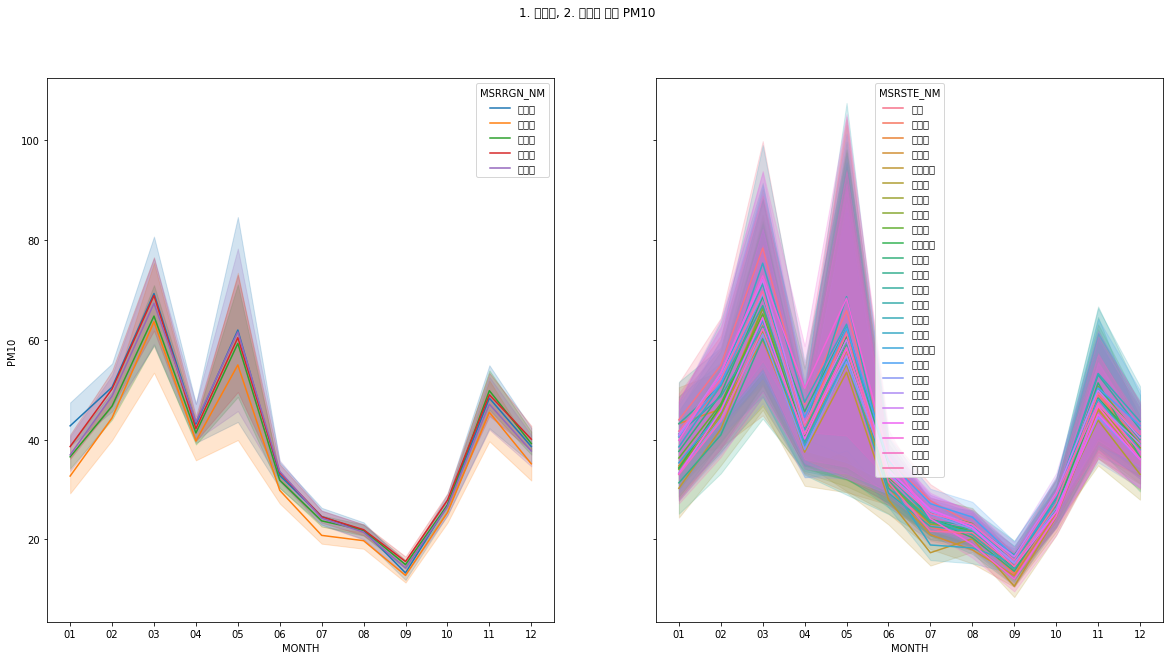

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
fig.suptitle('1. 구역별, 2. 지역별 평균 PM10')
sns.lineplot(ax = axes[0], x='MONTH', y='PM10', data=df, hue='MSRRGN_NM')
sns.lineplot(ax = axes[1], x='MONTH', y='PM10', data=df, hue='MSRSTE_NM')
plt.show()
# 8월 6월에 튀는 데이터가 존재 : 이상치 가능성
# 동대문구 8월을 보면 데이터가 0인 게 존재해 값이 매우 낮음.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_

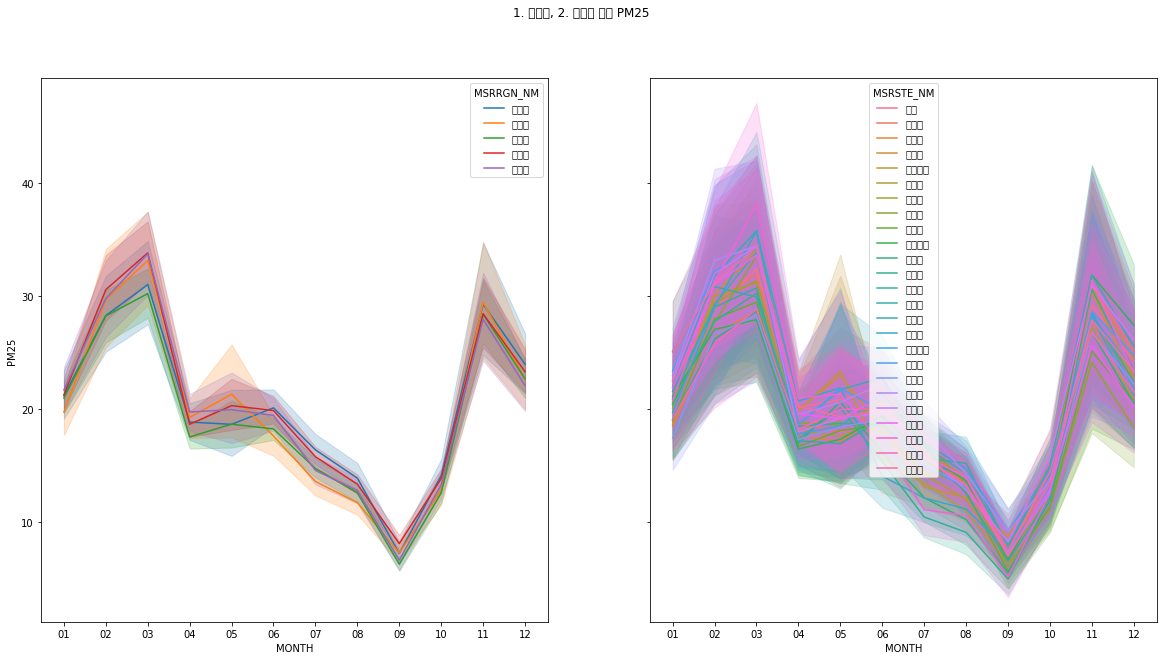

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
fig.suptitle('1. 구역별, 2. 지역별 평균 PM25')
sns.lineplot(ax = axes[0], x='MONTH', y='PM25', data=df, hue='MSRRGN_NM')
sns.lineplot(ax = axes[1], x='MONTH', y='PM25', data=df, hue='MSRSTE_NM')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text

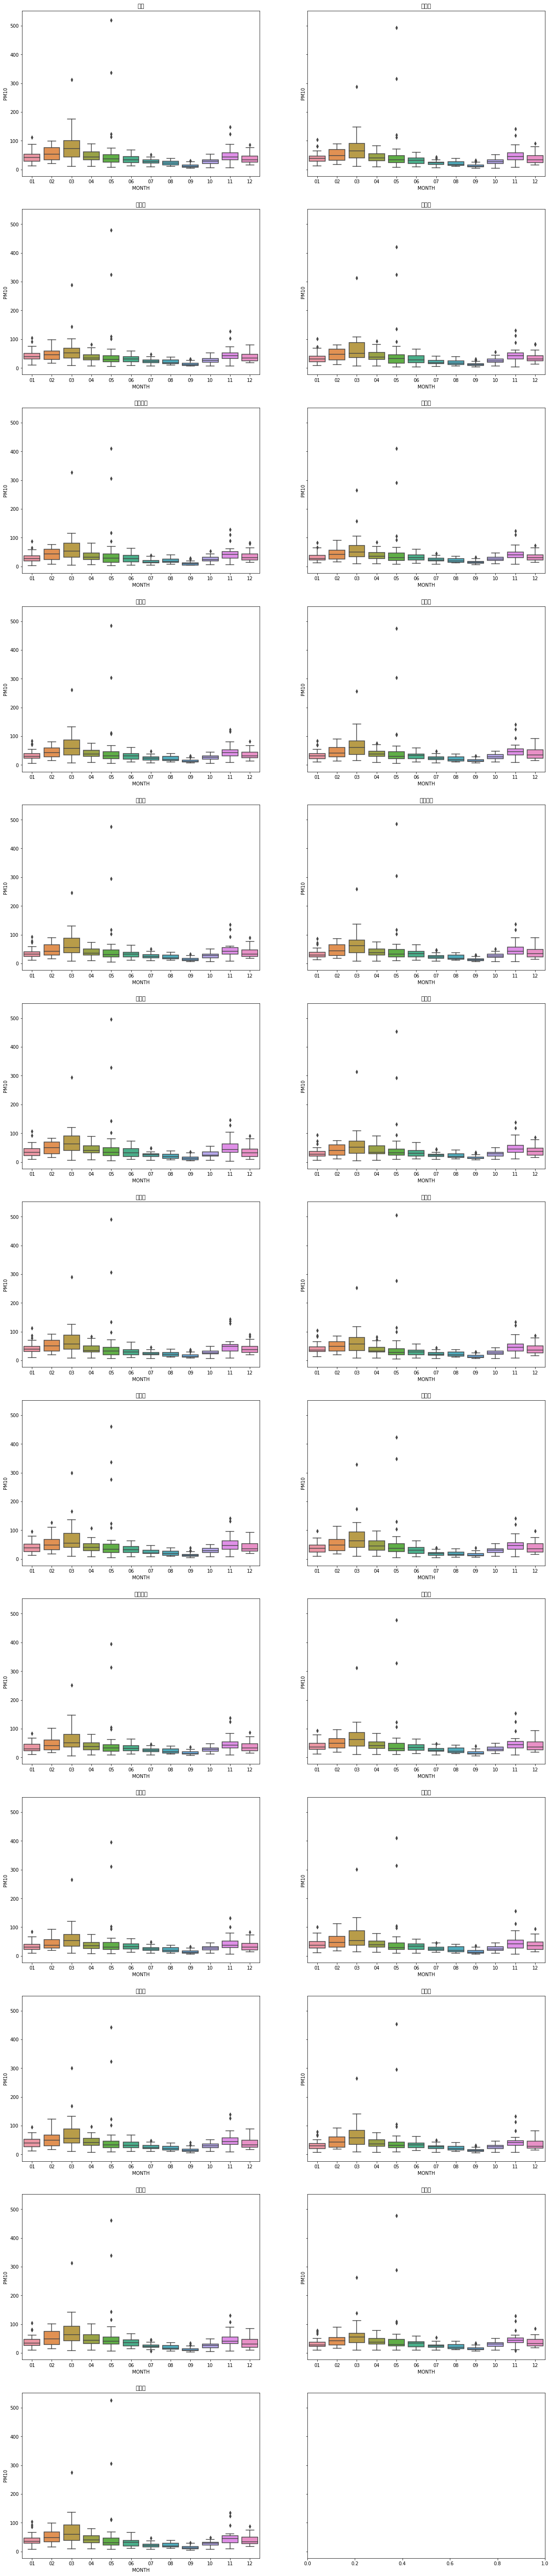

In [ ]:
UNIQUE = df['MSRSTE_NM'].unique()
fig, axes = plt.subplots(len(UNIQUE)//2 + 1, 2, figsize=(20, 100), sharey=True)
row = -1
for ind, col in enumerate(UNIQUE):
  if ind % 2 == 0:
    row += 1
  axes[row][ind % 2].set_title(col)
  sns.boxplot(ax = axes[row][ind % 2], x = 'MONTH', y = 'PM10', data = df.query('MSRSTE_NM == \'%s\''%col))
# 종로구 6월

In [ ]:
# 6월 17일 종로구 PM10은 이상치
# 이상치 판단 기준은? 
# -> 날짜 기준 IQR 범위 이상이면 이상치로 처리하겠음


def get_outlier(tmp_df=None, weight=1.5):
  quantile_25 = np.percentile(tmp_df.values, 25)
  quantile_75 = np.percentile(tmp_df.values, 75)
  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  outlier_idx = tmp_df[ (tmp_df < lowest) | (tmp_df > highest) ].index
  return outlier_idx

will_remove = []
for date in (df['MONTH'] +','+ df['DAY']).unique():
  month, day = date.split(',')
  rm_indexes = []
  rm_indexes.extend(get_outlier(df.query('MONTH == \'%s\' and DAY == \'%s\''%(month, day))['PM10']))
  rm_indexes.extend(get_outlier(df.query('MONTH == \'%s\' and DAY == \'%s\''%(month, day))['PM25']))
  if len(rm_indexes):
    rm_indexes = list(set(rm_indexes))
    will_remove.extend(np.array(rm_indexes))
# df.drop(will_remove, axis=0, inplace=True)

In [ ]:
groupdf = df.groupby(by = ['MONTH', 'DAY', 'MSRRGN_NM']).median()
def outlier_transform(df):
  columns = df.columns
  month, day, divi = 8, 9, 0
  o3, no2, co, so2 = 4, 5, 6, 7
  pm10, pm25 = 2, 3
  npdf = np.array(df)
  for index in will_remove:
    row = npdf[index]
    key = (row[month], row[day], row[divi])
    row[o3] = groupdf.loc[key]['O3']
    row[no2] = groupdf.loc[key]['NO2']
    row[co] = groupdf.loc[key]['CO']
    row[so2] = groupdf.loc[key]['SO2']
    row[pm10] = groupdf.loc[key]['PM10']
    row[pm25] = groupdf.loc[key]['PM25']
    npdf[index] = row
  return pd.DataFrame(npdf, columns = columns)
df = outlier_transform(df)
df.isna().sum()

MSRRGN_NM    0
MSRSTE_NM    0
PM10         0
PM25         0
O3           0
NO2          0
CO           0
SO2          0
MONTH        0
DAY          0
WEEKDAY      0
SEASON       0
dtype: int64

# LSTM Model

In [ ]:
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from tensorflow.keras import Input
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout, Bidirectional, Conv1D, Embedding, MaxPool1D
y_columns = ['PM10', 'PM25']

In [ ]:
division_encoder = LabelEncoder()
location_encoder = LabelEncoder()
df['MSRRGN_NM'] = division_encoder.fit_transform(df['MSRRGN_NM'])
df['MSRSTE_NM'] = location_encoder.fit_transform(df['MSRSTE_NM'])

In [ ]:
df = df.sort_values(by = ['MSRRGN_NM', 'MSRSTE_NM', 'MONTH', 'DAY'])
df = pd.concat([df, pd.get_dummies(df.WEEKDAY)], axis = 1)
df = df.drop('WEEKDAY', axis = 1)

In [ ]:
def split_sequence(sequence, n_steps):
    sequence, answer = sequence[:, :-2], sequence[:, -2:]
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps - 1
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix+1], answer[end_ix]
        if len(np.unique(seq_x[:,1])) > 1:
          continue
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)
df = df.astype(np.float32)
scaler = MinMaxScaler(feature_range=(0, 1))
df_tmp_x = scaler.fit_transform(df.drop(y_columns, axis = 1))
df_tmp_y = df[y_columns].values
df_tmp = np.concatenate([df_tmp_x, df_tmp_y], axis = 1)
X, Y = split_sequence(df_tmp, 7)
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.4)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from keras.callbacks import ModelCheckpoint
filename = 'chkpoint.h5'
checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')

model = Sequential()
model.add(Conv1D(128, 3, padding='same', strides=1, activation = 'tanh'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100, activation = 'tanh', return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(160, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(40, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(train_x, train_y, epochs=1000, batch_size=64, validation_data=(val_x, val_y), verbose=2, shuffle=True, callbacks = [checkpoint])
#최대 20

Epoch 1/1000

Epoch 1: val_loss improved from inf to 951.01807, saving model to chkpoint.h5
67/67 - 8s - loss: 1059.2576 - val_loss: 951.0181 - 8s/epoch - 114ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 951.01807 to 948.51447, saving model to chkpoint.h5
67/67 - 1s - loss: 802.2759 - val_loss: 948.5145 - 707ms/epoch - 11ms/step
Epoch 3/1000

Epoch 3: val_loss did not improve from 948.51447
67/67 - 1s - loss: 810.6772 - val_loss: 950.7872 - 604ms/epoch - 9ms/step
Epoch 4/1000

Epoch 4: val_loss did not improve from 948.51447
67/67 - 1s - loss: 805.6406 - val_loss: 950.9411 - 629ms/epoch - 9ms/step
Epoch 5/1000

Epoch 5: val_loss improved from 948.51447 to 936.16119, saving model to chkpoint.h5
67/67 - 1s - loss: 798.2523 - val_loss: 936.1612 - 702ms/epoch - 10ms/step
Epoch 6/1000

Epoch 6: val_loss improved from 936.16119 to 891.36420, saving model to chkpoint.h5
67/67 - 1s - loss: 745.0125 - val_loss: 891.3642 - 724ms/epoch - 11ms/step
Epoch 7/1000

Epoch 7: val_loss improved 

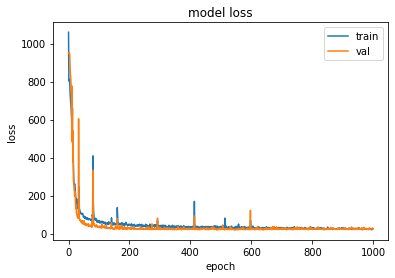

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model.load_weights(filename)
yhat = model.predict(test_x)
yhat

56/56 [==============================] - 1s 3ms/step


array([[11.989369 ,  6.0763354],
       [44.015656 , 25.222336 ],
       [33.69183  , 15.378574 ],
       ...,
       [34.22836  , 23.174248 ],
       [50.744534 , 32.760532 ],
       [27.958546 , 18.124763 ]], dtype=float32)

In [ ]:
mean_squared_error(yhat, test_y)

17.466343

In [ ]:
import joblib
joblib.dump(scaler, 'minmaxscaler.pkl')

['minmaxscaler.pkl']

In [ ]:
joblib.dump(division_encoder, 'division_encoder.pkl')
joblib.dump(location_encoder, 'location_encoder.pkl')

['location_encoder.pkl']